In [14]:
import sys
from pathlib import Path
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


transformer_module_path = str(Path.cwd().parent)
if transformer_module_path not in sys.path:
    sys.path.append(transformer_module_path)

from transformer.utils import set_seed, get_subsequent_mask, count_trainable_parameters
from transformer.model import Transformer
from transformer.losses import SmoothKLDivLoss, LossCalculator
from transformer.optim import OptimScheduler
from transformer.trainer import TrainConfig, Trainer, run_epoch_cycle
from transformer.metrics import Metric, MetricsEvaluator

from typing import List

In [15]:
set_seed(42)

### Inference Test

In [16]:
def inference_test():
    test_model = Transformer(10, 10, None, None, None, 10, 10, d_model=4, nhead=2, device='cpu')
    test_model.eval()
    src = torch.IntTensor([[x for x in range(10)]])
    src_mask = torch.ones(1, 1, 10)

    encoder_out = test_model.encode(src, src_mask)
    tgt = torch.zeros((1, 1), dtype=src.dtype)

    for _ in range(9):
        tgt_mask = get_subsequent_mask(tgt.size(1)).type_as(src).unsqueeze(0)
        decoder_out = test_model.decode(encoder_out, tgt, src_mask, tgt_mask)
        out_probs = test_model.compute_predictions(decoder_out[:, -1, :])
        _, next_token = torch.max(out_probs, dim=-1)
        tgt = torch.cat([tgt, next_token.unsqueeze(1)], dim=1).type_as(src)
    
    return tgt

In [17]:
for inf_pred_i in range(10):
    print(f'Untrained inference pred {inf_pred_i}: {inference_test()}')

Untrained inference pred 0: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]], dtype=torch.int32)
Untrained inference pred 1: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
Untrained inference pred 2: tensor([[0, 9, 9, 9, 9, 9, 9, 9, 9, 9]], dtype=torch.int32)
Untrained inference pred 3: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]], dtype=torch.int32)
Untrained inference pred 4: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)
Untrained inference pred 5: tensor([[0, 9, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)
Untrained inference pred 6: tensor([[0, 8, 8, 8, 8, 8, 8, 8, 8, 8]], dtype=torch.int32)
Untrained inference pred 7: tensor([[0, 7, 7, 7, 6, 6, 6, 6, 7, 7]], dtype=torch.int32)
Untrained inference pred 8: tensor([[0, 7, 7, 3, 9, 7, 9, 7, 6, 3]], dtype=torch.int32)
Untrained inference pred 9: tensor([[0, 7, 9, 6, 9, 6, 9, 6, 9, 6]], dtype=torch.int32)


# Simple Task Test

In [18]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Sorting Task

In [19]:
class SimpleTestDataset(Dataset):
    def __init__(self, src, tgt, pad_token_val) -> None:
        self.src = src
        self.tgt = tgt[:, :-1] # Exclude last token
        self.tgt_labels = tgt[:, 1:] # Exclude first token
        self.pad_token_val = pad_token_val
        self.src_mask = torch.stack([(seq != pad_token_val).unsqueeze(0).type_as(seq) for seq in self.src])
        self.tgt_mask = torch.stack([SimpleTestDataset.get_pad_subsequent_mask(seq, pad_token_val) for seq in self.tgt])
        self.tgt_token_num = torch.tensor([(seq != pad_token_val).sum() for seq in self.tgt_labels])
    
    @staticmethod
    def get_pad_subsequent_mask(seq, pad_token_val):
        pad_subseq_mask = (seq != pad_token_val)
        pad_subseq_mask = pad_subseq_mask & get_subsequent_mask(pad_subseq_mask.size(0))
        return pad_subseq_mask.type_as(seq)

    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return {
            'src': self.src[idx],
            'tgt': self.tgt[idx],
            'tgt_labels': self.tgt_labels[idx],
            'src_mask': self.src_mask[idx],
            'tgt_mask': self.tgt_mask[idx],
            'tgt_token_num': self.tgt_token_num[idx]
        }

In [20]:
def generate_data_sample(max_seq_len: int, pad_token_val: int, start_token_val: int, end_token_val: int, sample_values: torch.Tensor):
    sample_len = random.randint(3, max_seq_len)
    # Generate random values
    sample = sample_values[torch.randint(0, sample_values.size(0), size=(sample_len,))]
    sample[0] = start_token_val
    sample[-1] = end_token_val

    if sample_len < max_seq_len:
        sample_pad_extension = torch.tensor([pad_token_val] * (max_seq_len - sample_len))
        sample = torch.cat((sample, sample_pad_extension))
    
    sample = sample.requires_grad_(False).detach() 
    return sample

In [21]:
def simple_test_data_generation(sample_num: int, sample_values: torch.Tensor, max_seq_len: int, train_size: float = 0.7, test_size: float = 0.2, pad_token_val = 0, start_token_val = 1, end_token_val = 2):
    src, tgt = torch.empty(0, max_seq_len, dtype=torch.int32), torch.empty(0, max_seq_len, dtype=torch.int32)

    for _ in range(sample_num):
        sample = generate_data_sample(max_seq_len, pad_token_val, start_token_val, end_token_val, sample_values)
        sample.unsqueeze_(0)
        src = torch.cat([src, sample])
        # Copy-Paste Task
        # tgt = torch.cat([tgt, sample.clone()])
        # Sorting Task
        sorted_sample = sample.clone()
        sorted_sample[1:-1], _ = torch.sort(sorted_sample[1:-1])
        tgt = torch.cat([
            tgt,
            sorted_sample
        ])

    train_len = int(sample_num * train_size)
    test_len = int(sample_num * test_size)

    train_src, train_tgt = src[:train_len], tgt[:train_len]
    test_src, test_tgt = src[train_len : train_len+test_len], tgt[train_len : train_len+test_len]
    val_src, val_tgt = src[train_len+test_len:], tgt[train_len+test_len:]

    train_dataset, test_dataset, val_dataset = SimpleTestDataset(train_src, train_tgt, pad_token_val), SimpleTestDataset(test_src, test_tgt, pad_token_val), SimpleTestDataset(val_src, val_tgt, pad_token_val)
    return train_dataset, test_dataset, val_dataset

In [22]:
def calculate_accuracy(predictions: List[List[int]], references: List[List[int]]) -> float:
    predictions_tensor = torch.tensor(predictions)
    references_tensor = torch.tensor(references)

    predictions_tensor = predictions_tensor[:, 1:]
    
    correct_predictions = (predictions_tensor == references_tensor).sum().item()
    total_predictions = predictions_tensor.numel()
    
    return (correct_predictions / total_predictions)

In [23]:
def run_sample_custom_test(max_seq_len: int, pad_token_val: int, start_token_val: int, end_token_val: int, sample_values: torch.Tensor, model, src: torch.Tensor = None):
    if src is None:
        src = generate_data_sample(max_seq_len, pad_token_val=pad_token_val, start_token_val=start_token_val, end_token_val=end_token_val, sample_values=sample_values).unsqueeze(0)
    src_mask = torch.stack([(seq != pad_token_val).unsqueeze(0).type_as(seq) for seq in src])
    tgt = model.generate_sequences(src, src_mask)

    print('Custom test:')
    print(f'- Input: {src.squeeze(0)}')
    print(f'- Output: {tgt.squeeze(0)}')

In [24]:
def run_simple_test(epochs, vocab_len = 10, max_seq_len = 10, data_sample_num = 5000, batch_size = 40, use_custom_loss = False, save_model = False, checkpoint_save_freq = 0, verbose_batch_freq = 20):
    optim_lr = 0.001 # 0.0001
    optim_betas = (0.9, 0.98)
    optim_eps = 1e-9

    pad_token_val = 0
    start_token_val = 1
    end_token_val = 2
    special_tokens = [pad_token_val, start_token_val, end_token_val]
    vocab_len += 3

    num_encoder_layers = num_decoder_layers = 2
    label_smoothing = 0.001

    sample_values = torch.tensor([val for val in range(vocab_len) if val not in special_tokens])

    train_dataset, test_dataset, val_dataset = simple_test_data_generation(data_sample_num, sample_values, max_seq_len, pad_token_val=pad_token_val, start_token_val=start_token_val, end_token_val=end_token_val)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = Transformer(vocab_len, vocab_len, start_token_val, end_token_val, pad_token_val, max_seq_len, max_seq_len, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, device=DEVICE)

    print(f'Model\'s trainable params: {count_trainable_parameters(model):,}')

    if use_custom_loss:
        criterion = SmoothKLDivLoss(size=vocab_len, pad_token_idx=pad_token_val, label_smoothing=label_smoothing, reduction='sum')
        apply_softmax_last_layer = True
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=pad_token_val, label_smoothing=label_smoothing, reduction='sum')
        apply_softmax_last_layer = False

    optim_scheduler = OptimScheduler(
        optimizer=optim.Adam(model.parameters(), optim_lr, optim_betas, optim_eps),
        d_model=model.d_model,
        factor=1.0,
        warmup_steps=500
    )

    loss_calculator = LossCalculator(
        criterion=criterion,
        prediction_head=model.compute_predictions,
        apply_softmax=apply_softmax_last_layer
    )

    metrics_evaluator = MetricsEvaluator(
        metrics={
            'accuracy': Metric(calculate_accuracy, decode=False, best_value_criteria='max')
        }
    )

    model_save_path = '../model_checkpoints/tests' if save_model else None

    train_config = TrainConfig(
        epochs=epochs,
        device=DEVICE,
        batch_size=batch_size,
        checkpoint_save_freq=checkpoint_save_freq,
        model_save_path=model_save_path,
        model_save_prefix='best_model_simple_test',
    )

    # Train model
    trainer = Trainer(train_config, model, train_dataset, val_dataset, loss_calculator, optim_scheduler, metrics_evaluator)
    trainer.train(verbose_batch_freq=verbose_batch_freq)

    model.eval()
    print('')
    test_metrics = run_epoch_cycle(model, test_loader, loss_calculator, DEVICE, mode = 'test', metrics_evaluator=metrics_evaluator, verbose_freq=verbose_batch_freq)
    print('-> Test Metrics:')
    for metric, metric_value in test_metrics.items():
        print(f'\t- {metric}: {metric_value:.6f}')
        
    print('')

    # Custom Test
    custom_test_src = sample_values[:min(5, sample_values.size(0)-1)]
    random.shuffle(custom_test_src)
    custom_test_src[0], custom_test_src[-1] = start_token_val, end_token_val
    custom_test_src.unsqueeze_(0)
    run_sample_custom_test(
        max_seq_len=max_seq_len,
        pad_token_val=pad_token_val,
        start_token_val=start_token_val,
        end_token_val=end_token_val,
        sample_values=sample_values,
        model=model,
        src=custom_test_src
    )
    
    # Plot Loss History
    loss_history = pd.DataFrame.from_dict(trainer.loss_history)
    loss_history['epoch'] = loss_history.index
    loss_history = pd.melt(loss_history, id_vars='epoch', value_vars=[loss_type for loss_type in trainer.loss_history.keys()], var_name='loss_type', value_name='loss')

    sns.lineplot(data=loss_history, x='epoch', y='loss', hue='loss_type', marker='o')
    plt.grid(True)
    plt.legend(title='Loss History')
    plt.show()

    # Plot Val Metrics History
    val_metrics_history = pd.DataFrame.from_dict(trainer.val_metrics_history)
    val_metrics_history['epoch'] = val_metrics_history.index
    val_metrics_history = pd.melt(val_metrics_history, id_vars='epoch', value_vars=[metric for metric in trainer.val_metrics_history.keys()], var_name='metric_type', value_name='metric')

    sns.lineplot(data=val_metrics_history, x='epoch', y='metric', hue='metric_type', marker='o')
    plt.grid(True)
    plt.legend(title='Val Metrics History')
    plt.show()


Model's trainable params: 14,714,888
Trainer running on device: cuda
** Epoch 1:
Mode: train
	Batch 1 - 0.71% | Loss: 3.204090 | Accum. Tokens: 196 | LR: 4.0e-09
	Batch 16 - 11.43% | Loss: 3.358427 | Accum. Tokens: 3524 | LR: 6.3e-08
	Batch 31 - 22.14% | Loss: 3.222373 | Accum. Tokens: 6893 | LR: 1.2e-07
	Batch 46 - 32.86% | Loss: 3.170130 | Accum. Tokens: 10266 | LR: 1.8e-07
	Batch 61 - 43.57% | Loss: 3.036087 | Accum. Tokens: 13657 | LR: 2.4e-07
	Batch 76 - 54.29% | Loss: 2.971851 | Accum. Tokens: 16852 | LR: 3.0e-07
	Batch 91 - 65.0% | Loss: 2.788835 | Accum. Tokens: 20186 | LR: 3.6e-07
	Batch 106 - 75.71% | Loss: 2.707212 | Accum. Tokens: 23520 | LR: 4.2e-07
	Batch 121 - 86.43% | Loss: 2.659805 | Accum. Tokens: 26812 | LR: 4.8e-07
	Batch 136 - 97.14% | Loss: 2.419100 | Accum. Tokens: 30131 | LR: 5.4e-07

Mode: val
	Batch 1 - 5.0% | Loss: 2.218900 | Accum. Tokens: 212
	Batch 16 - 80.0% | Loss: 2.251466 | Accum. Tokens: 3513

-> Train Loss: 2.945406 | Val Loss: 2.234635 | Best Val Lo

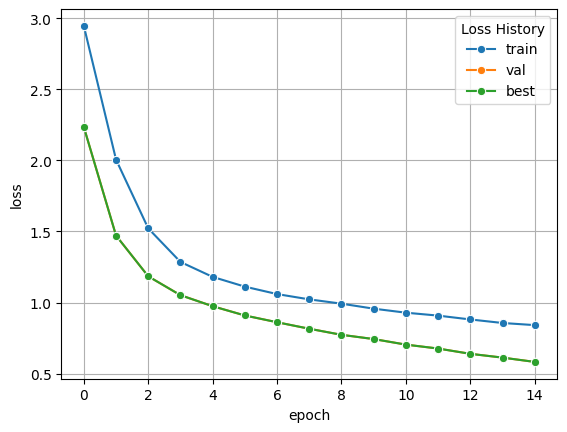

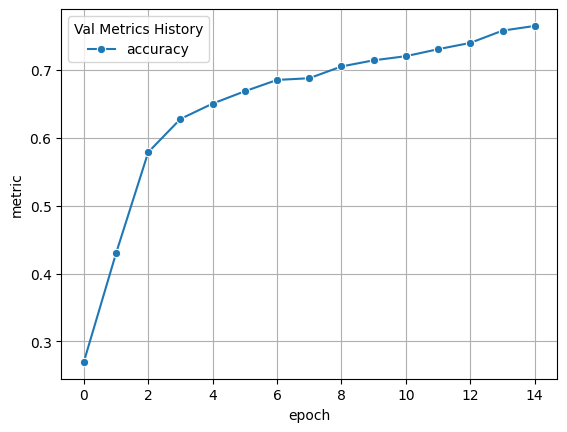

In [25]:
# Cross Entropy Loss
run_simple_test(
    epochs=15,
    vocab_len=5,
    max_seq_len=10,
    data_sample_num=8000,
    batch_size=40,
    use_custom_loss=False,
    save_model=False,
    verbose_batch_freq=15
)

Model's trainable params: 14,714,888
Trainer running on device: cuda
** Epoch 1:
Mode: train
	Batch 1 - 0.71% | Loss: 3.125177 | Accum. Tokens: 225 | LR: 4.0e-09
	Batch 16 - 11.43% | Loss: 2.962265 | Accum. Tokens: 3499 | LR: 6.3e-08
	Batch 31 - 22.14% | Loss: 2.967937 | Accum. Tokens: 6753 | LR: 1.2e-07
	Batch 46 - 32.86% | Loss: 3.130100 | Accum. Tokens: 9997 | LR: 1.8e-07
	Batch 61 - 43.57% | Loss: 2.991669 | Accum. Tokens: 13274 | LR: 2.4e-07
	Batch 76 - 54.29% | Loss: 2.896427 | Accum. Tokens: 16632 | LR: 3.0e-07
	Batch 91 - 65.0% | Loss: 2.615063 | Accum. Tokens: 20078 | LR: 3.6e-07
	Batch 106 - 75.71% | Loss: 2.603055 | Accum. Tokens: 23402 | LR: 4.2e-07
	Batch 121 - 86.43% | Loss: 2.386173 | Accum. Tokens: 26719 | LR: 4.8e-07
	Batch 136 - 97.14% | Loss: 2.433372 | Accum. Tokens: 30020 | LR: 5.4e-07

Mode: val
	Batch 1 - 5.0% | Loss: 2.324229 | Accum. Tokens: 217
	Batch 16 - 80.0% | Loss: 2.160442 | Accum. Tokens: 3496

-> Train Loss: 2.798387 | Val Loss: 2.212888 | Best Val Los

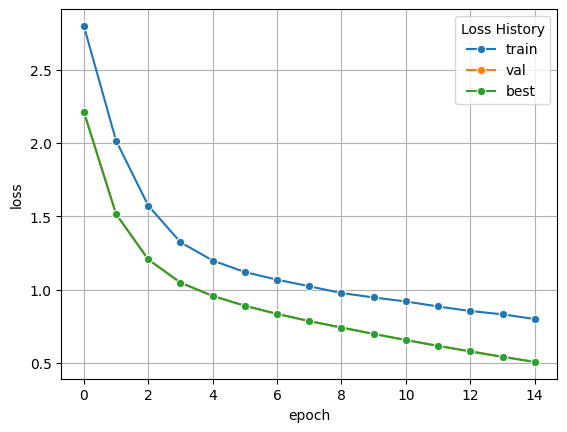

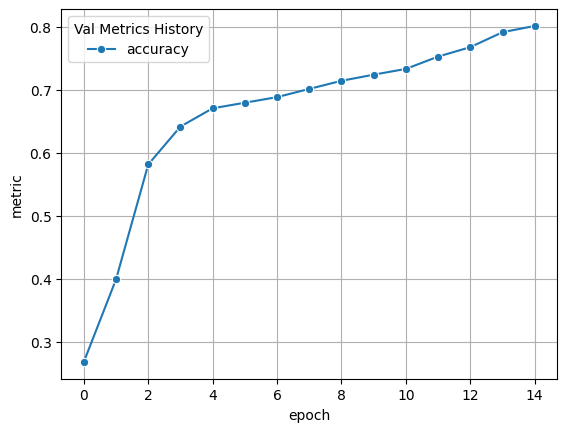

In [26]:
# KLDivLoss
run_simple_test(
    epochs=15,
    vocab_len=5,
    max_seq_len=10,
    data_sample_num=8000,
    batch_size=40,
    use_custom_loss=True,
    save_model=False,
    verbose_batch_freq=15
)